## <center>Midterm Lab
```
- Advanced Machine Learning, Innopolis University 
- Professor: Muhammad Fahim 
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>

```
Tasks:
  1. Image Transform (5 points)
  2. CNN model declaration (10 points)
  3. CNN model training (5 points)
  4. Transfer Learning or Viterbi algorithm : Bonus (5 points)
```

<hr>

## The Dataset

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Task 1 : Preprocessing of Dataset (5 points)

1.   Create the transforms:
    * Resize images to (32 * 32)
    * Normalize every channel (mean and std of your choice)
    * Apply one more data augmentation technique you know (i.e Rotation, translation, RandomErasing, RandomHorizontalFlip etc.)


**Hint**: data augmentation techniques shouldn't be applied to the test dataset.

In [2]:
transform_train = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.RandomRotation((0, 45)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

trainset = torchvision.datasets.SVHN(root='./data/train', split="train", download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

testset = torchvision.datasets.SVHN(root='./data/test', split="test", download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=1)

classes = [f"{i}" for i in np.unique(trainset.labels)]

Using downloaded and verified file: ./data/train/train_32x32.mat
Using downloaded and verified file: ./data/test/test_32x32.mat


## Task 1.1 Plot Classes distribution 

Plot the distribution of classes in the training sample on a bar graph

Text(0, 0.5, 'Counts')

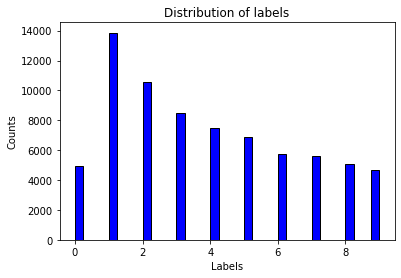

In [3]:
from matplotlib import pyplot as plt

#TODO: Plot the distribution of classes

plt.hist(trainset.labels, color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Distribution of labels')
plt.xlabel('Labels')
plt.ylabel('Counts')

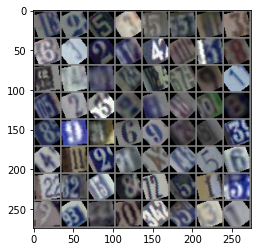

In [4]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 3, 32, 32)
    return x

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# sample a batch and show 
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

## Task 2 : Build a classisfication convolutional neural network


The Model should should have the following achitecture : 
1. 3 Convolution layers : (5 points)
    * conv1 : 2 kernels, 3*3 kernel size, stride 1.
    * conv2 : 4 kernels, 5*5 kernel size, stride 2.
    * conv3 : 8 kernels, 3*3 kernel size, stride 1.
    * Add 1 Avarage pooling layer after 2nd layer and 1 Max-pooling layer before the fully connected layers.
    * Stride for all pooling operations set to 1 
    
    
2. Fully connected layers : 
    * fc1 : 64 output-neurons with a relu activation.
    * output_layer : final layer with no activation function
    * Add Dropout layer after the first (fc1) layer with 25% dropout probability

3. Implement the foward pass method for the CNN  (5 points)
    * Add an activation function of your own choice after every layer
    

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #TODO: Declare the model layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2) # Max Pooling (2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) # Convolution
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10) # output layer with 10 neurones

    def forward(self, x):
        # TODO: Implement the forward pass
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # flatten the output of previous layer using x.view(...)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Task 3 : Convolutional neural network training precedure (5 points)

Implement the model training procedure and select the appropriate loss function

In [13]:
# Model accuracy calculator 
def accuracy_calc(net,testloader,device):
    correct = 0
    total = 0
    with torch.no_grad():
        i=0
        for data in testloader:
            i+=1
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

In [7]:
model = Net().to(device)
model

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [25]:
#Set hyper parameters 
nb_epoch = 3
lr = 0.001

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss() #TODO: Define the Loss function (criterion)

def train(model,trainloader,optimizer, criterion, device):
    #TODO : Implement the training procedure of the model at each an every epoch. It should return model loss and accuracy on training sample
    epoch_loss = 0
    epoch_accuracy = 0
    
    model.train()
    
    for batch in trainloader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        predictions = model(x).squeeze(1)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    acc = accuracy_calc(model, trainloader, device)
    return epoch_loss / len(trainloader) , acc

In [26]:
for epoch in range(nb_epoch):
    print('epoch:', epoch)
    epochLoss, epochAcc = train(model,trainloader, optimizer, criterion, device)
    print(f"Epoch : {epoch}, Loss {epochLoss}, Accuracy {epochAcc}")

epoch: 0
Epoch : 0, Loss 2.251070642887765, Accuracy 0.18921058738414076
epoch: 1
Epoch : 1, Loss 2.234969785640333, Accuracy 0.18921058738414076
epoch: 2
Epoch : 2, Loss 2.232254634257487, Accuracy 0.18921058738414076


## Task 4 (bonus) : Use pretrained CNN model or Viterbi implementation (5 points)

**Option 1** : Import any pretrained model and train on CIFAR10. Print out the loss and accuracy at each an every epoch. Number of training epochs and optimizer are of your choice. <br>
**OPtion 2** : Implement the viterbi algorithm (from previous lab task POS tagging) 

Option 1:

In [39]:
import torchvision.models as models
vgg16 = models.vgg16(pretrained=True,progress=True)

In [40]:
transform = transforms.Compose(
    [transforms.Resize((32,32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [41]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.net = models.vgg16(pretrained=True,progress=True)
        self.net.trainable = False
        self.net.fc = nn.Linear(1000, 10)

    def forward(self, x):
        return self.net(x)


net = Net()
net = net.to(device)

In [42]:
for epoch in range(nb_epoch):
    epochLoss, epochAcc = train(model,trainloader, optimizer, criterion, device)
    print(f"Epoch : {epoch}, Loss {epochLoss}, Accuracy {epochAcc}")

Epoch : 0, Loss 1.6588145195043087, Accuracy 0.49182
Epoch : 1, Loss 1.320209855413437, Accuracy 0.57126
Epoch : 2, Loss 1.1695042723354698, Accuracy 0.63082


Option 2:

Data link: https://github.com/Gci04/AML-DS-2021/tree/main/data/PosTagging  

Please download it manually.

In [27]:
def data_prep_hmm(path):
  with open(path) as f:
    train_data = f.read()
  data = []
  for line in train_data.split("\n \n"):
    if line=='':
      continue
    sen=[]  
    for word in line.split("\n"):
      seq = word.split(" ")
      sen.append((seq[0], seq[1]))
    data.append(sen)
  return data

train_set, test_set = data_prep_hmm("train_pos.txt"), data_prep_hmm("test_pos.txt")  

In [30]:
import numpy as np
import pandas as pd
import random
import pprint, time

# create list of train and test tagged words
train_tagged_words = [ tup for sent in train_set for tup in sent ]
test_tagged_words = [ tup for sent in test_set for tup in sent ]

#use set datatype to check how many unique tags are present in training data
tags = {tag for word,tag in train_tagged_words}

# check total words in vocabulary
vocab = {word for word,tag in train_tagged_words}

In [31]:
# compute Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)#total number of times the passed tag occurred in train_bag
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    #now calculate the total number of times the passed word occurred as the passed tag.
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag, count_tag)

# compute  Transition Probability
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

tags_matrix = np.zeros((len(tags), len(tags)), dtype='float32')
for i, t1 in enumerate(list(tags)):
    for j, t2 in enumerate(list(tags)): 
        P_t_tprev, P_t = t2_given_t1(t2, t1)
        tags_matrix[i, j] = P_t_tprev/P_t

# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(tags), index=list(tags))
display(tags_df)

def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
     
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = np.log(tags_df.loc['.', tag])
            else:
                transition_p = np.log(tags_df.loc[state[-1], tag])
                 
            # compute emission and state probabilities
            P_t_tprev, P_t = word_given_tag(words[key], tag)
            emission_p = np.log(P_t_tprev) - np.log(P_t)
            state_probability = emission_p + transition_p    
            p.append(state_probability)
             
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))


# Let's test our Viterbi algorithm on a few sample sentences of test dataset
random.seed(111)
 
# Here we will only test 10 sentences to check the accuracy
rndom = [random.randint(1,len(test_set)) for x in range(10)]

test_run = [test_set[i] for i in rndom] 
test_run_base = [tup for sent in test_run for tup in sent]
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
tagged_seq = Viterbi(test_tagged_words)
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Viterbi Algorithm Accuracy: ',accuracy*100)


,VB,VBP,),$,CC,NNPS,'',RB,VBN,RBR,(,RP,#,DT,WP,UH,WP$,WRB,RBS,NNP,``,EX,FW,JJ,.,",",MD,POS,IN,SYM,CD,VBZ,VBG,NNS,JJR,PDT,NN,JJS,VBD,WDT,TO,PRP,:,PRP$
VB,0.006814,0.000166,0.000000,0.007977,0.011135,0.000831,0.003490,0.045538,0.085092,0.002327,0.000499,0.004487,0.000166,0.210902,0.003158,0.000000,0.000000,0.005152,0.000831,0.028087,0.004986,0.000831,0.000000,0.082433,0.026093,0.016952,0.000831,0.000166,0.139771,0.000000,0.020774,0.002493,0.016287,0.058335,0.013462,0.000831,0.065481,0.000166,0.001330,0.000997,0.047033,0.033738,0.001828,0.048529
VBP,0.005230,0.001046,0.000000,0.002092,0.003835,0.000349,0.000697,0.163529,0.150279,0.004184,0.000697,0.002092,0.000000,0.111925,0.002441,0.000000,0.000000,0.003138,0.001395,0.015690,0.005579,0.002092,0.000000,0.082287,0.024407,0.024059,0.001395,0.000000,0.094840,0.000000,0.009066,0.003138,0.090307,0.033473,0.009763,0.001743,0.032427,0.000000,0.009066,0.001743,0.054742,0.031729,0.003835,0.015690
),0.010676,0.021352,0.000000,0.000000,0.046263,0.003559,0.000000,0.017794,0.010676,0.000000,0.000000,0.000000,0.000000,0.060498,0.003559,0.000000,0.000000,0.003559,0.000000,0.064057,0.007117,0.000000,0.000000,0.021352,0.124555,0.149466,0.024911,0.000000,0.128114,0.000000,0.007117,0.067616,0.000000,0.024911,0.000000,0.000000,0.049822,0.000000,0.028470,0.000000,0.028470,0.014235,0.081851,0.000000
$,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000571,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000571,0.000000,0.000000,0.000000,0.004000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.985143,0.000000,0.000571,0.000000,0.000000,0.000000,0.009143,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CC,0.033321,0.008377,0.000186,0.025503,0.000000,0.002234,0.000000,0.045421,0.021035,0.002048,0.000186,0.000186,0.000000,0.110759,0.002048,0.000186,0.000186,0.004095,0.003351,0.161020,0.006888,0.004468,0.000000,0.106292,0.000372,0.006143,0.011355,0.000000,0.048771,0.000000,0.051564,0.021407,0.022338,0.071668,0.012472,0.000372,0.122487,0.000186,0.035741,0.000745,0.007818,0.032204,0.000000,0.016567
NNPS,0.002381,0.071429,0.000000,0.000000,0.078571,0.004762,0.002381,0.004762,0.007143,0.000000,0.000000,0.000000,0.000000,0.004762,0.014286,0.000000,0.000000,0.000000,0.000000,0.042857,0.000000,0.000000,0.000000,0.014286,0.107143,0.171429,0.035714,0.033333,0.104762,0.000000,0.000000,0.026190,0.011905,0.014286,0.002381,0.000000,0.076190,0.000000,0.121429,0.000000,0.030952,0.000000,0.016667,0.000000
'',0.004019,0.003349,0.000670,0.000670,0.057602,0.000000,0.007368,0.038178,0.006028,0.000000,0.010047,0.000000,0.000000,0.100469,0.002679,0.000000,0.000000,0.004689,0.000000,0.138647,0.014735,0.002679,0.000000,0.018084,0.000670,0.001340,0.008038,0.000000,0.132619,0.000000,0.004689,0.139987,0.012726,0.029471,0.000000,0.000000,0.043537,0.001340,0.083054,0.008707,0.015405,0.095780,0.008707,0.004019
RB,0.109732,0.031179,0.000151,0.015287,0.007114,0.000303,0.001059,0.058877,0.086272,0.004692,0.000151,0.000000,0.000303,0.050704,0.001665,0.000000,0.000000,0.003481,0.000303,0.006811,0.001059,0.000605,0.000151,0.102770,0.062509,0.093234,0.011503,0.000454,0.129257,0.000151,0.022855,0.041017,0.030725,0.004995,0.017406,0.000454,0.008022,0.000605,0.050552,0.000454,0.025428,0.011200,0.003784,0.002724
VBN,0.001050,0.001050,0.001050,0.008188,0.013227,0.000210,0.002939,0.042410,0.031283,0.001680,0.000210,0.000840,0.000210,0.064665,0.000840,0.000000,0.000000,0.002939,0.000210,0.030863,0.004829,0.000000,0.000000,0.045560,0.044720,0.029813,0.001470,0.000000,0.363216,0.000000,0.018686,0.001680,0.015956,0.044300,0.005669,0.000420,0.090909,0.000000,0.001050,0.000420,0.104976,0.008188,0.003989,0.010288
RBR,0.003115,0.006231,0.000000,0.000000,0.015576,0.000000,0.000000,0.109034,0.021807,0.000000,0.000000,0.000000,0.000000,0.099688,0.000000,0.000000,0.000000,0.000000,0.000000,0.003115,0.000000,0.000000,0.000000,0.367601,0.208723,0.065421,0.000000,0.003115,0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log


Viterbi Algorithm Accuracy:  88.42105263157895
